In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
pd.options.mode.chained_assignment = None

In [145]:
type = "crc"

# variable STRs
all_vstr = pd.read_csv("./exp_paired/" + type + "_vstr.csv")
estr = pd.read_csv("./output/" + type + "_estr.csv")
all_vstr["allele_diff"] = all_vstr["allele_a_diff"] + all_vstr["allele_b_diff"]
all_vstr = all_vstr.query("allele_diff != 0")

# gene expression change from paired samples
exp_diff = pd.read_csv("./exp_paired/" + type.upper() + "_gene_pair_2.csv", index_col = "Unnamed: 0")
gene_pred = all_vstr.loc[all_vstr["patient"].isin(exp_diff.columns) & all_vstr["tmp_id"].isin(estr["str_id"]),
            ["tmp_id", "patient", "allele_diff"]]
# eSTR 
gene_pred = gene_pred.merge(estr[["str_id", "coef", "gene"]], 
                            left_on = "tmp_id", right_on = "str_id", how = "left")


In [1034]:
permut_accs = []
i = 0
while(i < 10000):
    
    mean_effect = gene_pred["coef"].mean()
    std_effect = gene_pred["coef"].std()

    gene_pred["permut_coef"] = np.random.normal(mean_effect, std_effect, size=len(gene_pred["coef"]))
    gene_pred["permut_exp"] = gene_pred["allele_diff"]*gene_pred["permut_coef"]

    exp_diff["gene"] = exp_diff.index
    diff_melt = pd.melt(exp_diff, id_vars = exp_diff.columns[-1], 
            value_vars = exp_diff.columns[:-1])
    gene_permut_true = gene_pred.merge(diff_melt, 
                                       left_on = ["patient", "gene"], right_on = ["variable", "gene"])
    permut_acc = gene_permut_true.loc[gene_permut_true["permut_exp"]*gene_permut_true["value"] > 0].shape[0]/gene_permut_true.shape[0]
    permut_accs.append(permut_acc)
    i=i+1

In [1035]:
(np.sum(np.array(permut_accs) >= 0.556) + 1) / (10000 + 1)

9.999000099990002e-05

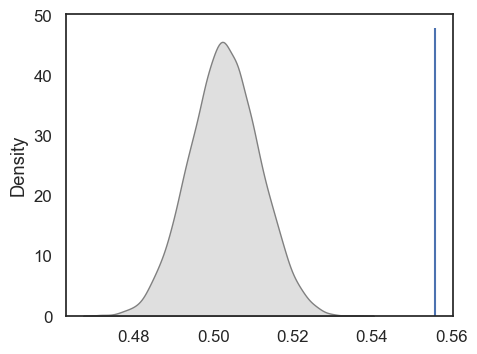

In [1036]:
fig, axes = plt.subplots(1, 1, figsize=(5, 4), dpi = 100)
sns.set_theme(style = "white", font_scale = 1.1)
axes = sns.kdeplot(x = permut_accs, 
                   fill = True, 
                  # common_norm= False,
                  # stat="density",
                   color = "gray")
axes.vlines(x = 0.556, 
            ymin=0,
            ymax = axes.get_ylim()[1],
            color = sns.color_palette()[0])
#axes.text( "P = 0.003")

In [21]:
type = "ucec"
# variable STRs
all_vstr = pd.read_csv("./exp_paired/" + type + "_vstr.csv")

# eSTR 
estr = pd.read_csv("./output/" + type + "_estr.csv")
all_vstr["allele_diff"] = all_vstr["allele_a_diff"] + all_vstr["allele_b_diff"]
all_vstr = all_vstr.query("allele_diff != 0")

# gene expression change from paired samples
exp_diff = pd.read_csv("./exp_paired/" + type.upper() + "_gene_pair.csv", index_col = "Unnamed: 0")
gene_pred = all_vstr.loc[all_vstr["patient"].isin(exp_diff.columns) & all_vstr["tmp_id"].isin(estr["str_id"]),
            ["tmp_id", "patient", "allele_diff"]]
gene_pred = gene_pred.merge(estr[["str_id", "coef", "gene"]], 
                            left_on = "tmp_id", right_on = "str_id", how = "left")
gene_pred["pred_exp"] = gene_pred["allele_diff"]*gene_pred["coef"]

exp_diff["gene"] = exp_diff.index
diff_melt = pd.melt(exp_diff, id_vars = exp_diff.columns[-1], 
        value_vars = exp_diff.columns[:-1])
gene_pred_true = gene_pred.merge(diff_melt, left_on = ["patient", "gene"], right_on = ["variable", "gene"])

exp_diff["gene"] = exp_diff.index
diff_melt = pd.melt(exp_diff, id_vars = exp_diff.columns[-1], 
        value_vars = exp_diff.columns[:-1])
gene_pred_true = gene_pred.merge(diff_melt, left_on = ["patient", "gene"], right_on = ["variable", "gene"])

overall_acc = gene_pred_true.loc[gene_pred_true["pred_exp"]*gene_pred_true["value"] > 0].shape[0]/gene_pred_true.shape[0]

gene_pred_true["abs_diff"] = abs(gene_pred_true["allele_diff"])
gene_pred_true["abs_exp"] = abs(gene_pred_true["pred_exp"])
gene_pred_true = gene_pred_true.sort_values(by = "abs_exp")
# gene_pred_true["bins"] = pd.cut(range(0, gene_pred_true.shape[0]), bins= nbin).codes + 1
# per_dir = []
# for i in range(1,nbin+1):
#         test = gene_pred_true.query("bins == {}".format(i))
#         tmp = test.loc[test["pred_exp"]*test["value"] > 0].shape[0]/test.shape[0]
#         per_dir.append(tmp)
# bins_data = pd.DataFrame({"bins": range(1,nbin+1), 
#                                 "per":per_dir,
#                                 "ave_exp" : gene_pred_true[["bins", "abs_exp"]].groupby("bins").mean("abs_exp")["abs_exp"]})

diff_length = gene_pred_true.value_counts("abs_diff").to_frame(name = "num").query("num > 5").index
# gene_pred_len = gene_pred_true.loc[gene_pred_true["abs_diff"].isin(diff_length)]
# diff = gene_pred_len["abs_diff"].unique()
# per_diff = []
# for i in diff:
#         test = gene_pred_len.query("abs_diff == {}".format(i))
#         tmp = test.loc[test["pred_exp"]*test["value"] > 0].shape[0]/test.shape[0]
#         per_diff.append(tmp)
# diff_data = pd.DataFrame({"diff": diff, "per":per_diff})

# same_dir = gene_pred_true.loc[gene_pred_true["pred_exp"]*gene_pred_true["value"] > 0]
# same_dir["acc"] = 1- abs((same_dir["pred_exp"] - same_dir["value"])/same_dir["value"])

# bins_acc = same_dir.query("acc > 0")
# diff_acc = bins_acc.loc[bins_acc["abs_diff"].isin(diff_length)]

In [23]:
same_dir = gene_pred_true.loc[gene_pred_true["pred_exp"]*gene_pred_true["value"] > 0]
same_dir = same_dir.loc[same_dir["abs_diff"].isin(diff_length)]

In [24]:
same_dir.shape[0],gene_pred_true.shape[0]

(49, 107)

In [25]:
epslion = 1e-6
same_dir["acc"] = 1- abs((same_dir["pred_exp"] - same_dir["value"])/(same_dir["value"]+epslion))
same_dir["bs_acc"] = 1- abs((0 - same_dir["value"])/(same_dir["value"]+epslion))

In [26]:
same_dir.query("bs_acc > 0").shape

(23, 13)

In [27]:
same_dir.query("acc > 0").shape

(42, 13)

<AxesSubplot:xlabel='abs_diff', ylabel='bs_acc'>

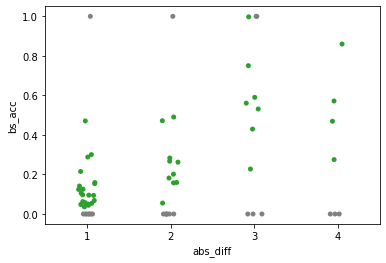

In [ ]:
sns.stripplot(data = same_dir.query("acc > 0"), y = "acc", x = "abs_diff", color = sns.color_palette("tab10")[2])
sns.stripplot(data = same_dir.query("bs_acc > 0"), y = "bs_acc", x = "abs_diff", color = "gray")

<AxesSubplot:>

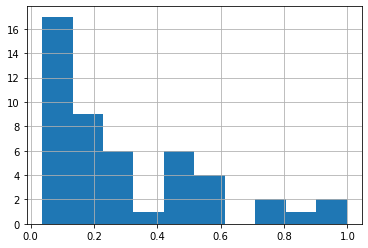

In [14]:
same_dir.query("acc > 0")["acc"].hist()

In [ ]:
sns.histplot(data = same_dir.query("acc > 0"), x = "acc")

<AxesSubplot:xlabel='abs_diff', ylabel='bs_acc'>

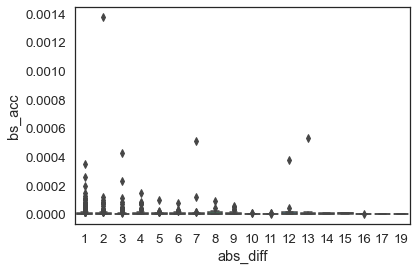

In [168]:
sns.plot(data = same_dir.query("bs_acc > 0"), x = "abs_diff", y = "bs_acc")

In [26]:
def cancer_type(type= "crc", nbin = 12):
        # variable STRs
        all_vstr = pd.read_csv("./exp_paired/" + type + "_vstr.csv")
        all_vstr["allele_diff"] = all_vstr["allele_a_diff"] + all_vstr["allele_b_diff"]
        all_vstr = all_vstr.query("allele_diff != 0")

        # gene expression change from paired samples
        exp_diff = pd.read_csv("./exp_paired/" + type.upper() + "_gene_pair.csv", index_col = "Unnamed: 0")
        estr = pd.read_csv("./output/" + type + "_estr.csv")
        gene_pred = all_vstr.loc[all_vstr["patient"].isin(exp_diff.columns) & all_vstr["tmp_id"].isin(estr["str_id"]),
                ["tmp_id", "patient", "allele_diff"]]
   
        gene_pred = gene_pred.merge(estr[["str_id", "coef", "gene"]], 
                                left_on = "tmp_id", right_on = "str_id", how = "left")
        gene_pred["pred_exp"] = gene_pred["allele_diff"]*gene_pred["coef"]

        exp_diff["gene"] = exp_diff.index
        diff_melt = pd.melt(exp_diff, id_vars = exp_diff.columns[-1], 
                value_vars = exp_diff.columns[:-1])
        gene_pred_true = gene_pred.merge(diff_melt, left_on = ["patient", "gene"], right_on = ["variable", "gene"])
        
        overall_acc = gene_pred_true.loc[gene_pred_true["pred_exp"]*gene_pred_true["value"] > 0].shape[0]/gene_pred_true.shape[0]
        
        gene_pred_true["abs_diff"] = abs(gene_pred_true["allele_diff"])
        gene_pred_true["abs_exp"] = abs(gene_pred_true["pred_exp"])
        gene_pred_true = gene_pred_true.sort_values(by = "abs_exp")
        gene_pred_true["bins"] = pd.cut(range(0, gene_pred_true.shape[0]), bins= nbin).codes + 1
        per_dir = []
        for i in range(1,nbin+1):
                test = gene_pred_true.query("bins == {}".format(i))
                tmp = test.loc[test["pred_exp"]*test["value"] > 0].shape[0]/test.shape[0]
                per_dir.append(tmp)
        bins_data = pd.DataFrame({"bins": range(1,nbin+1), 
                                  "per":per_dir,
                                  "ave_exp" : gene_pred_true[["bins", "abs_exp"]].groupby("bins").mean("abs_exp")["abs_exp"]})
        
        diff_length = gene_pred_true.value_counts("abs_diff").to_frame(name = "num").query("num > 5").index
        gene_pred_len = gene_pred_true.loc[gene_pred_true["abs_diff"].isin(diff_length)]
        diff = gene_pred_len["abs_diff"].unique()
        per_diff = []
        for i in diff:
                test = gene_pred_len.query("abs_diff == {}".format(i))
                tmp = test.loc[test["pred_exp"]*test["value"] > 0].shape[0]/test.shape[0]
                per_diff.append(tmp)
        diff_data = pd.DataFrame({"diff": diff, "per":per_diff})
        
        same_dir = gene_pred_true.loc[gene_pred_true["pred_exp"]*gene_pred_true["value"] > 0]
        same_dir["acc"] = 1- abs((same_dir["pred_exp"] - same_dir["value"])/same_dir["value"])
        
        bins_acc = same_dir.query("acc > 0")
        diff_acc = bins_acc.loc[bins_acc["abs_diff"].isin(diff_length)]
        
        return overall_acc, bins_data, diff_data, bins_acc, diff_acc

In [118]:
crc_pred = cancer_type("crc", nbin =15) 
stad_pred = cancer_type("stad", nbin = 10) 
ucec_pred = cancer_type("ucec", nbin= 5) 

In [86]:
crc_pred[3].shape, crc_pred[4].shape

((1613, 13), (152, 13), (48, 13))

In [74]:
crc_pred[0], stad_pred[0], ucec_pred[0]

(0.5560704355885079, 0.5752508361204013, 0.5327102803738317)

<AxesSubplot:xlabel='ave_exp', ylabel='per'>

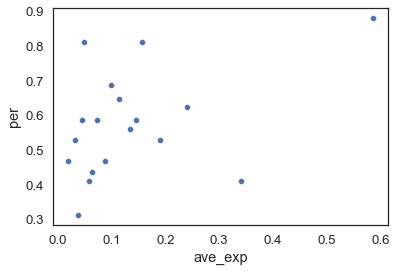

In [87]:
sns.scatterplot(data=stad_pred[1], x = "ave_exp", y = "per")

Text(0.5, 0, 'eSTR mutation length')

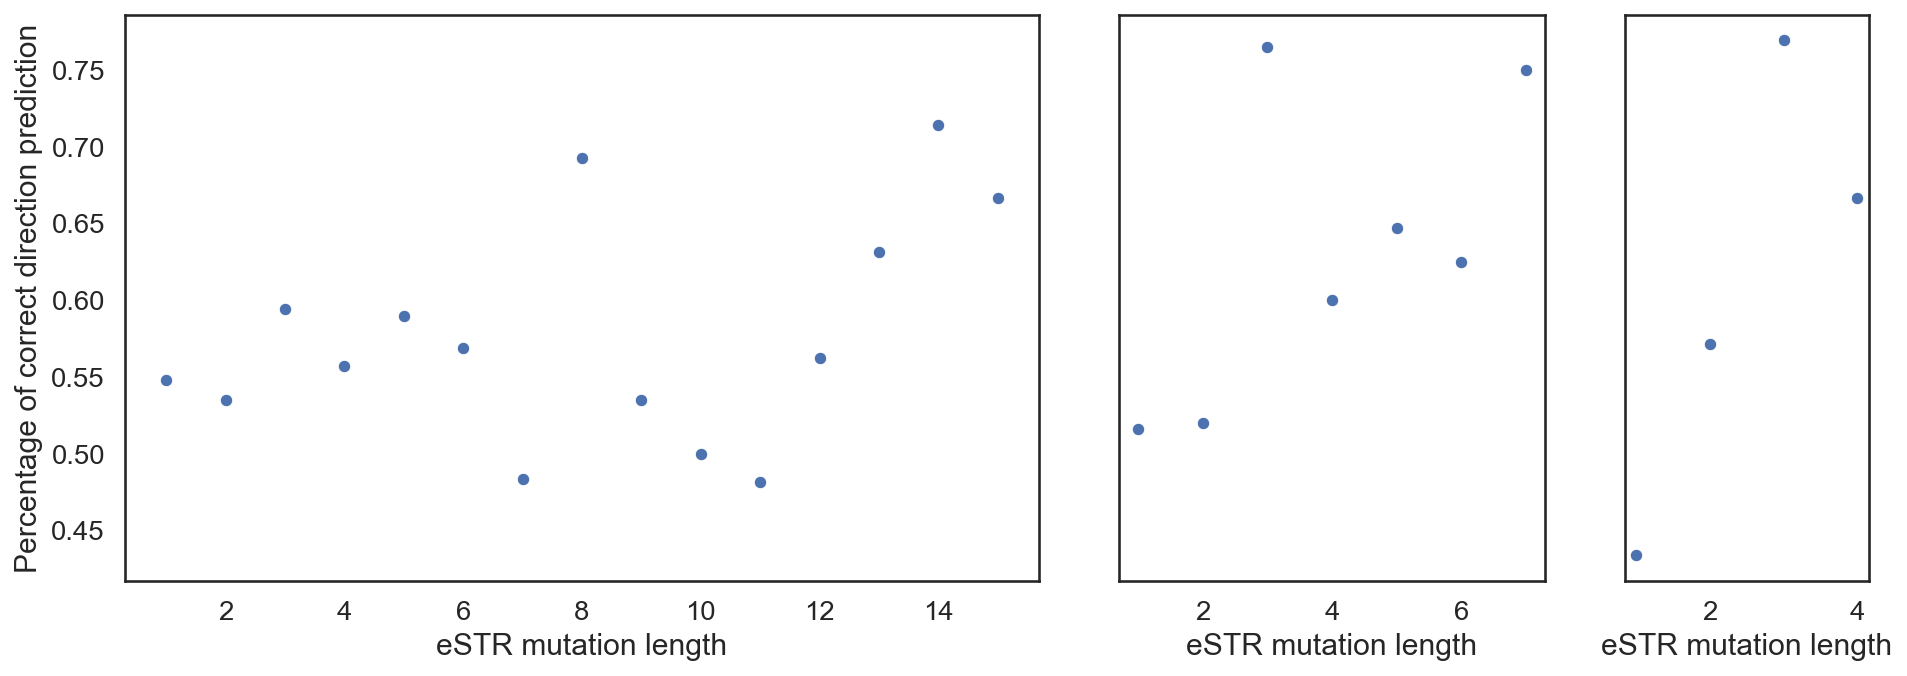

In [131]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi = 150, sharey = True, 
                         gridspec_kw={'width_ratios': [15,7,4]})
# custom_params = {"axes.spines.right": False, "axes.spines.top": False}
# sns.set_theme(style="white", rc=custom_params, font_scale = 1.1)
sns.set_theme(style="white", font_scale = 1.2)
fig.subplots_adjust(wspace=0.15)

sns.scatterplot(ax = axes[0],
     data = crc_pred[2],        
    x = "diff", y = "per")
axes[0].set_xlabel("eSTR mutation length")
axes[0].set_ylabel("Percentage of correct direction prediction")

sns.scatterplot(ax = axes[1],
    data = stad_pred[2],
    x = "diff", y = "per")
axes[1].set_xlabel("eSTR mutation length")

sns.scatterplot(ax = axes[2],
    data = ucec_pred[2], 
    x = "diff", y = "per")
axes[2].set_xlabel("eSTR mutation length")

In [132]:
(stats.pearsonr(crc_pred[2]["diff"], crc_pred[2]["per"]), stats.pearsonr(stad_pred[2]["diff"], stad_pred[2]["per"]),
stats.pearsonr(ucec_pred[2]["diff"], ucec_pred[2]["per"]))

((0.3783457284713433, 0.16436300313235205),
 (0.6190396383733416, 0.13827310311076316),
 (0.8108434478571324, 0.18915655214286764))

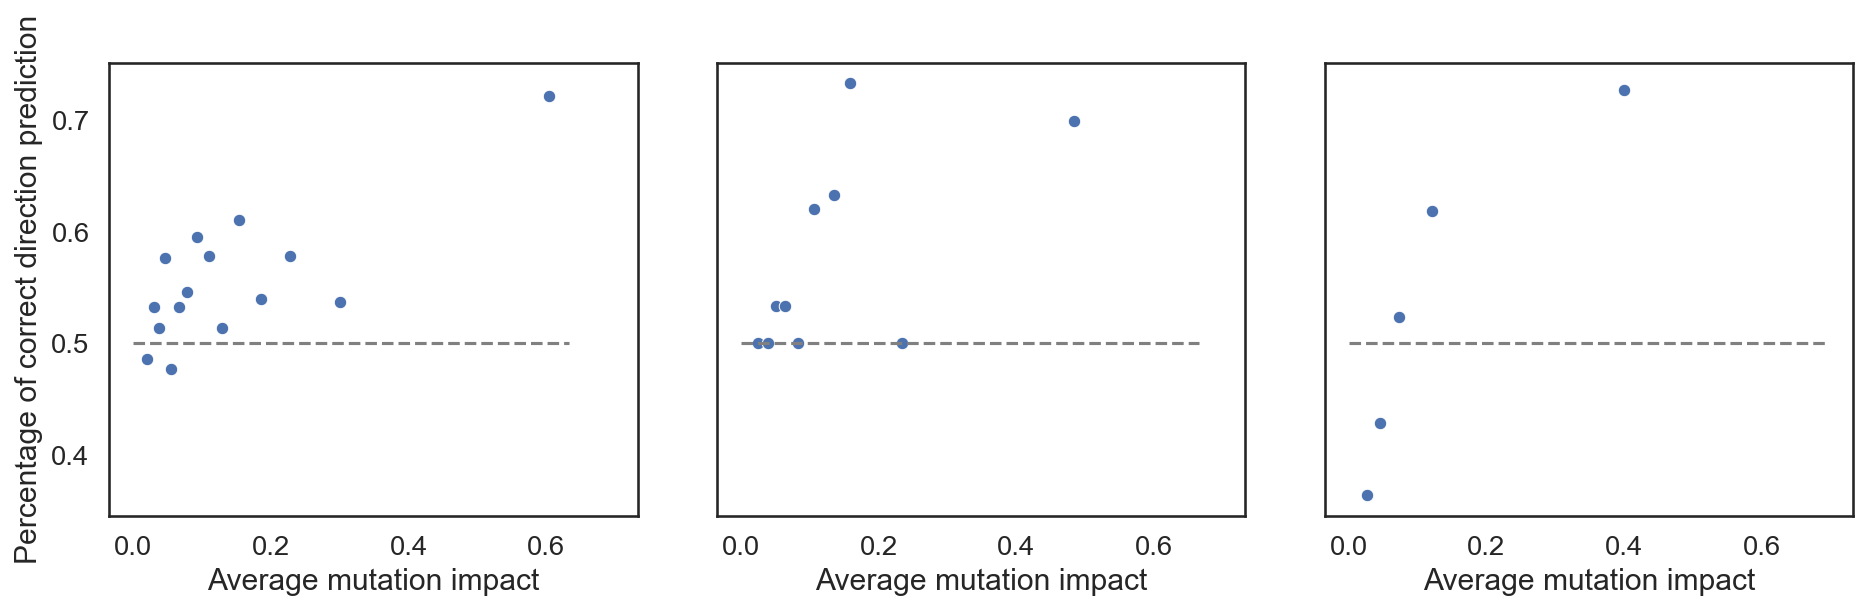

In [135]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), dpi = 150, sharey = True, sharex=True)
                        # gridspec_kw={'width_ratios': [15,7,4]})
# custom_params = {"axes.spines.right": False, "axes.spines.top": False}
# sns.set_theme(style="white", rc=custom_params, font_scale = 1.1)
sns.set_theme(style="white", font_scale = 1.2)
fig.subplots_adjust(wspace=0.15)

sns.scatterplot(ax = axes[0],
     data = crc_pred[1],        
    x = "ave_exp", y = "per")
axes[0].set_xlabel("Average mutation impact")
axes[0].set_ylabel("Percentage of correct direction prediction")
axes[0].hlines(y = 0.5, 
            xmin=0,
            xmax = axes[0].get_xlim()[1],
            color = "gray", 
            linestyles = "dashed")

sns.scatterplot(ax = axes[1],
    data = stad_pred[1],
    x = "ave_exp", y = "per")
axes[1].set_xlabel("Average mutation impact")
axes[1].hlines(y = 0.5, 
            xmin=0,
            xmax = axes[1].get_xlim()[1],
            color = "gray", 
            linestyles = "dashed")

sns.scatterplot(ax = axes[2],
    data = ucec_pred[1], 
    x = "ave_exp", y = "per")
axes[2].set_xlabel("Average mutation impact")
axes[2].hlines(y = 0.5, 
            xmin=0,
            xmax = axes[2].get_xlim()[1],
            color = "gray", 
            linestyles = "dashed")

In [121]:
(stats.pearsonr(crc_pred[1]["ave_exp"], crc_pred[1]["per"]), stats.pearsonr(stad_pred[1]["ave_exp"], stad_pred[1]["per"]),
stats.pearsonr(ucec_pred[1]["ave_exp"], ucec_pred[1]["per"]))

((0.764703999593521, 0.0008978813198638513),
 (0.5842775460819306, 0.07610681664228243),
 (0.8795033415939331, 0.049293176673567723))

Text(0.0, 1.0, 'UCEC')

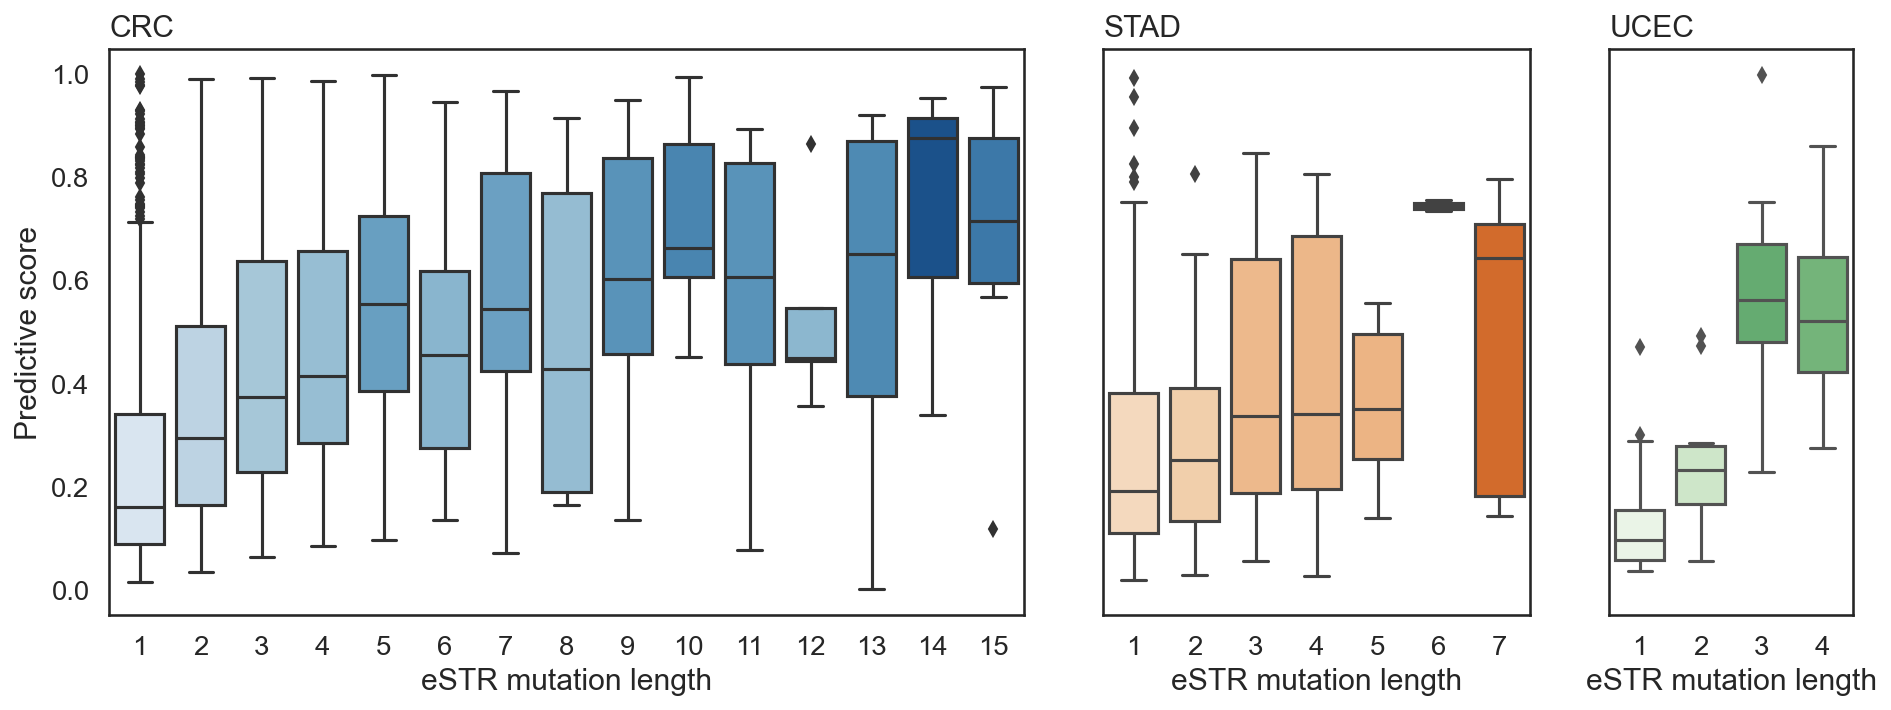

In [140]:
crc_group = crc_pred[4].groupby("abs_diff").median("acc")[["acc"]]
crc_group.columns = ["group"]
crc_group["group"] = crc_group["group"]*100
group_dict = {}
for i,j in crc_group["group"].astype(np.int64).iteritems():
    group_dict.update({i : sns.color_palette("Blues",100)[j]})
    
stad_group = stad_pred[4].groupby("abs_diff").median("acc")[["acc"]]
stad_group.columns = ["group"]
stad_group["group"] = stad_group["group"]*100
stad_dict = {}
for i,j in stad_group["group"].astype(np.int64).iteritems():
    stad_dict.update({i : sns.color_palette("Oranges",100)[j]})
    
ucec_group = ucec_pred[4].groupby("abs_diff").median("acc")[["acc"]]
ucec_group.columns = ["group"]
ucec_group["group"] = ucec_group["group"]*100
ucec_dict = {}
for i,j in ucec_group["group"].astype(np.int64).iteritems():
    ucec_dict.update({i : sns.color_palette("Greens",100)[j]})

fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi = 150, sharey = True, 
                         gridspec_kw={'width_ratios': [15,7,4]})
# custom_params = {"axes.spines.right": False, "axes.spines.top": False}
# sns.set_theme(style="white", rc=custom_params, font_scale = 1.1)
sns.set_theme(style="white", font_scale = 1.2)
fig.subplots_adjust(wspace=0.15)

sns.boxplot(ax = axes[0],
            data = crc_pred[4],
            x = "abs_diff", 
            y = "acc", 
            palette = group_dict
          )
axes[0].set_ylabel("Predictive score")
axes[0].set_xlabel("eSTR mutation length")
axes[0].set_title("CRC", loc = "left")

sns.boxplot(ax = axes[1],
            data = stad_pred[4],
            x = "abs_diff", 
            y = "acc", 
            palette = stad_dict
            )
axes[1].set_ylabel("")
axes[1].set_xlabel("eSTR mutation length")
axes[1].set_title("STAD", loc = "left")

sns.boxplot(ax = axes[2],
            data = ucec_pred[4],
            x = "abs_diff", 
            y = "acc", 
            palette = ucec_dict)
axes[2].set_ylabel("")
axes[2].set_xlabel("eSTR mutation length")
axes[2].set_title("UCEC", loc = "left")

In [124]:
crc_group = crc_pred[3].groupby("bins").median("acc")[["acc"]]
crc_group.columns = ["group"]
crc_group["group"] = crc_group["group"]*100
group_dict = {}
for i,j in crc_group["group"].astype(np.int64).iteritems():
    group_dict.update({i : sns.color_palette("Blues",100)[j]})
    
stad_group = stad_pred[3].groupby("bins").median("acc")[["acc"]]
stad_group.columns = ["group"]
stad_group["group"] = stad_group["group"]*100
stad_dict = {}
for i,j in stad_group["group"].astype(np.int64).iteritems():
    stad_dict.update({i : sns.color_palette("Oranges",100)[j]})
    
ucec_group = ucec_pred[3].groupby("bins").median("acc")[["acc"]]
ucec_group.columns = ["group"]
ucec_group["group"] = ucec_group["group"]*100
ucec_dict = {}
for i,j in ucec_group["group"].astype(np.int64).iteritems():
    ucec_dict.update({i : sns.color_palette("Greens",100)[j]})

Text(0.0, 1.0, 'UCEC')

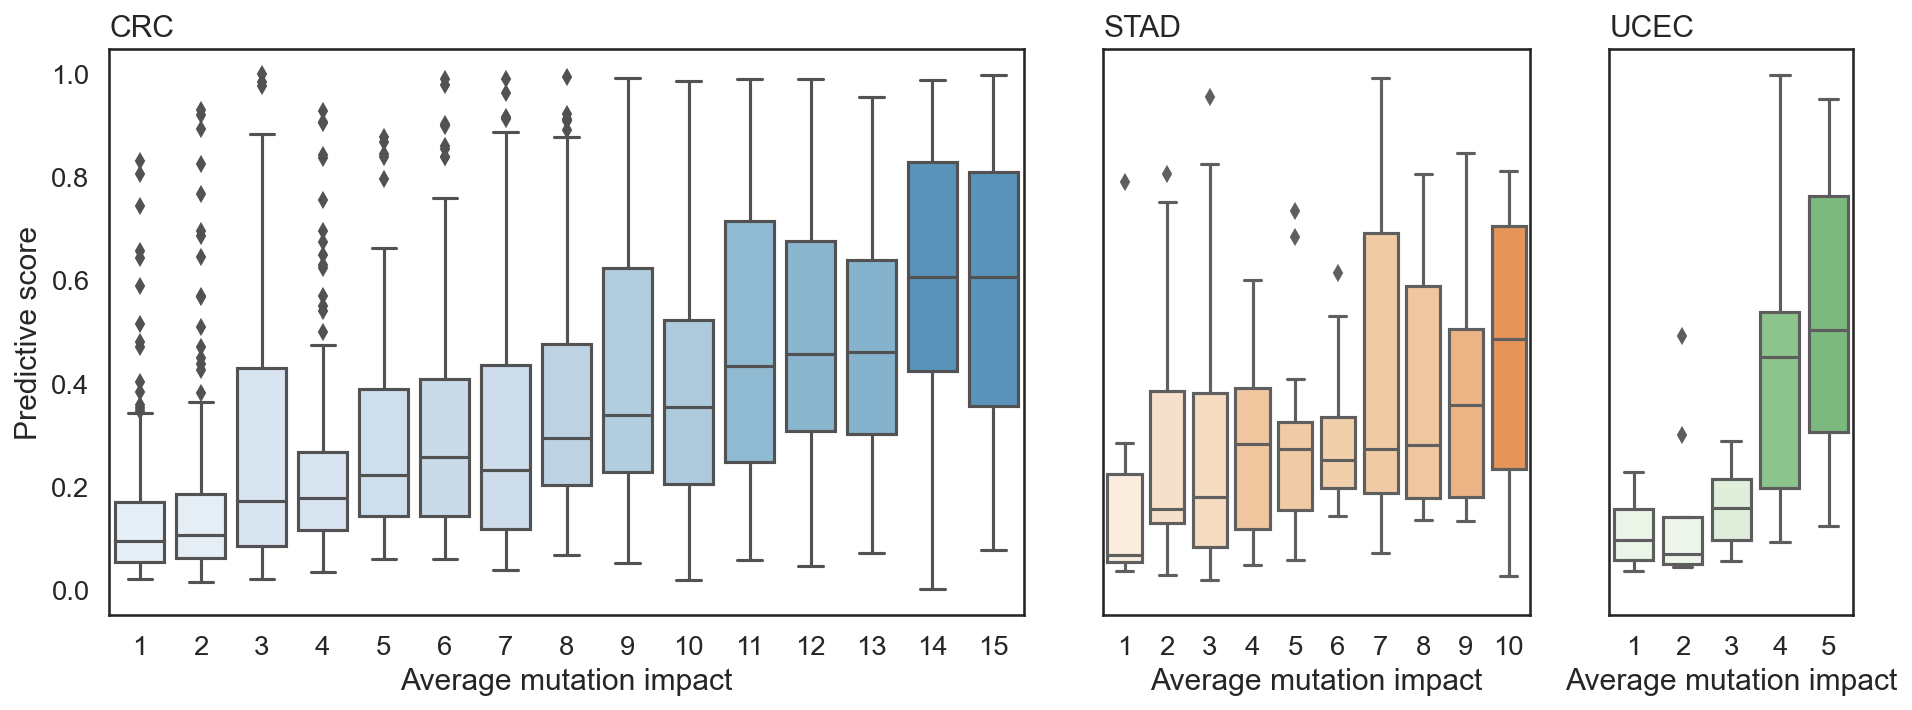

In [139]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi = 150, sharey = True, 
                         gridspec_kw={'width_ratios': [15,7,4]})
# custom_params = {"axes.spines.right": False, "axes.spines.top": False}
# sns.set_theme(style="white", rc=custom_params, font_scale = 1.1)
sns.set_theme(style="white", font_scale = 1.2)
fig.subplots_adjust(wspace=0.15)

sns.boxplot(ax = axes[0],
            data = crc_pred[3],
            x = "bins", 
            y = "acc", 
            palette = group_dict
          )
axes[0].set_ylabel("Predictive score")
axes[0].set_xlabel("Average mutation impact")
axes[0].set_title("CRC", loc = "left")

sns.boxplot(ax = axes[1],
            data = stad_pred[3],
            x = "bins", 
            y = "acc", 
            palette = stad_dict
            )
axes[1].set_ylabel("")
axes[1].set_xlabel("Average mutation impact")
axes[1].set_title("STAD", loc = "left")

sns.boxplot(ax = axes[2],
            data = ucec_pred[3],
            x = "bins", 
            y = "acc", 
            palette = ucec_dict)
axes[2].set_ylabel("")
axes[2].set_xlabel("Average mutation impact")
axes[2].set_title("UCEC", loc= "left")

In [126]:
stats.pearsonr(crc_pred[3]["abs_exp"], crc_pred[3]["acc"]), stats.pearsonr(crc_pred[4]["abs_diff"], crc_pred[4]["acc"])

((0.3437919335367514, 5.734208163719779e-46),
 (0.3897489271495631, 2.2683465453315027e-59))

In [127]:
stats.pearsonr(stad_pred[3]["abs_exp"], stad_pred[3]["acc"]), stats.pearsonr(stad_pred[4]["abs_diff"], stad_pred[4]["acc"])

((0.20060285908561543, 0.013211193753621677),
 (0.27834253089804467, 0.0005878231793818058))

In [129]:
stats.pearsonr(ucec_pred[3]["abs_exp"], ucec_pred[3]["acc"]), stats.pearsonr(ucec_pred[4]["abs_diff"], ucec_pred[4]["acc"])

((0.5082465167834568, 0.00022602870587948434),
 (0.7301300118742917, 4.081457487547064e-08))